In [19]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns

import tensorflow as tf
!pip install transformers

import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel

from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)
print(transformers.__version__)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2.11.0
4.28.1


# 📋 Loading the Data

**Public Dataset Link:**

https://www.kaggle.com/datasets/seriousran/appletwittersentimenttexts

In [20]:
import pandas as pd
import numpy as np
!pip install gensim nltk
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings("ignore")
#df = pd.read_csv('/kaggle/input/uk-twitter-covid19-dataset/sample_data.csv')
df = pd.read_csv('/kaggle/input/appletwittersentimenttexts/apple-twitter-sentiment-texts.csv')
#df = pd.read_csv('/kaggle/input/external-covid-19-twitter-dataset/Reddit_Data.csv')
#df = pd.read_csv('/kaggle/input/external-covid-19-twitter-dataset/Twitter_Data.csv')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1630 non-null   object
 1   sentiment  1630 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.6+ KB
None


In [22]:
df = df.dropna()
df

,text,sentiment
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,What Happened To Apple Inc? http://t.co/FJEX...,0
2,Thank u @apple I can now compile all of the pi...,1
3,The oddly uplifting story of the Apple co-foun...,0
4,@apple can i exchange my iphone for a differen...,0
...,...,...
1625,Those** PICK UP THE SLACK YOU FUCK BOYS @Apple,-1
1626,Finally got my iPhone 6 in the mail and it com...,-1
1627,@umo_games @Apple ended up getting a new compu...,0
1628,The 19-Year-Old #WizKid Who Turned Down @Apple...,0


In [23]:
#df['text'] = df['clean_tweet']
#df['target'] = df['senti_textblob']
#df['text'] = df['clean_text']
df['target'] = df['sentiment']

In [24]:
'''
import pandas as pd

# assuming your dataframe is named 'df'
num_samples_per_label = 2000

# group the dataframe by the label column
grouped_df = df.groupby('target')

# sample a specified number of rows from each group
sampled_df = grouped_df.apply(lambda x: x.sample(n=num_samples_per_label))

# reset the index of the resulting dataframe
sampled_df = sampled_df.reset_index(drop=True)
df = sampled_df 
'''

"\nimport pandas as pd\n\n# assuming your dataframe is named 'df'\nnum_samples_per_label = 2000\n\n# group the dataframe by the label column\ngrouped_df = df.groupby('target')\n\n# sample a specified number of rows from each group\nsampled_df = grouped_df.apply(lambda x: x.sample(n=num_samples_per_label))\n\n# reset the index of the resulting dataframe\nsampled_df = sampled_df.reset_index(drop=True)\ndf = sampled_df \n"

In [25]:
#df = df.drop(columns = ['text','sentiment'])
df = df.drop(columns = ['sentiment'])
df

,text,target
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,What Happened To Apple Inc? http://t.co/FJEX...,0
2,Thank u @apple I can now compile all of the pi...,1
3,The oddly uplifting story of the Apple co-foun...,0
4,@apple can i exchange my iphone for a differen...,0
...,...,...
1625,Those** PICK UP THE SLACK YOU FUCK BOYS @Apple,-1
1626,Finally got my iPhone 6 in the mail and it com...,-1
1627,@umo_games @Apple ended up getting a new compu...,0
1628,The 19-Year-Old #WizKid Who Turned Down @Apple...,0


In [26]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[['text','target']], test_size = 0.2, random_state = 42)

In [27]:
train

,text,target
808,"RT @Vito_sfam: Hey @apple, the battery of my i...",-1
1010,Yo @Apple wtf is wrong with you people? Make i...,-1
1041,RT @JPDesloges: APPLE - Fibonacci Technicals L...,0
682,MacBook Pro 13in Unboxing: http://t.co/F3IM9Yb...,0
1597,"If you have an iPad 2, DON'T update it to iOS8...",-1
...,...,...
1130,@BlackBerry I kinda feel sorry for @Apple tho....,-1
1294,Your iPad game just got shut way down. Like 24...,-1
860,Been waiting 7 days so far for @apple to appro...,-1
1459,MY T-MOBILE/APPLE CELLULAR HELL! http://t.co/G...,-1


In [28]:
print("train, counts of label '1': {}".format(sum(train.target == 1)))
print("train, counts of label '0': {}".format(sum(train.target == 0)))
print("train, counts of label '-1': {}\n".format(sum(train.target == -1)))
print("test, counts of label '1': {}".format(sum(test.target == 1)))
print("test, counts of label '0': {}".format(sum(test.target == 0)))
print("test, counts of label '-1': {}".format(sum(test.target == -1)))

train, counts of label '1': 119
train, counts of label '0': 636
train, counts of label '-1': 549

test, counts of label '1': 24
test, counts of label '0': 165
test, counts of label '-1': 137


In [29]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

#train = reduce_mem_usage(train)
#train = reduce_mem_usage(test)

In [30]:
'''
import pandas as pd

# assume your test data is stored in a pandas DataFrame called 'test'
# and the labels are stored in a column called 'target'

# randomly sample 1000 rows from each label
label_1 = test[test.target == 1].sample(n=1000, replace=False)
label_0 = test[test.target == 0].sample(n=1000, replace=False)
label_minus_1 = test[test.target == -1].sample(n=1000, replace=False)

# concatenate the sampled rows into one DataFrame
sampled_data = pd.concat([label_1, label_0, label_minus_1])

# shuffle the DataFrame
test = sampled_data.sample(frac=1).reset_index(drop=True)
'''

"\nimport pandas as pd\n\n# assume your test data is stored in a pandas DataFrame called 'test'\n# and the labels are stored in a column called 'target'\n\n# randomly sample 1000 rows from each label\nlabel_1 = test[test.target == 1].sample(n=1000, replace=False)\nlabel_0 = test[test.target == 0].sample(n=1000, replace=False)\nlabel_minus_1 = test[test.target == -1].sample(n=1000, replace=False)\n\n# concatenate the sampled rows into one DataFrame\nsampled_data = pd.concat([label_1, label_0, label_minus_1])\n\n# shuffle the DataFrame\ntest = sampled_data.sample(frac=1).reset_index(drop=True)\n"

In [31]:
test

,text,target
670,Strategic steps towards Full-Time #Trading htt...,0
251,RT @HorseshoeBmore #Holiday #Giveaway! To ensu...,0
1225,Elgato Launches Thunderbolt 2 Dock with 4K Res...,0
300,"YES. RT @garrett_wollman: No, @Apple, don't '...",-1
352,UBS Says Consensus on December Quarter Apple ...,0
...,...,...
306,Yeeaaayyy....awesome OS X Yosemite 10.10.1 roc...,1
192,.@Apple is reportedly hiring fashion-focused s...,0
309,Lol RT @Ms_BiAnCa_BiSa: @MhDaDon @Apple I hav...,0
613,@Apple YH News Apple's antitrust lawsuit may n...,0


In [32]:
#train2, test2 = train, test

# 🔨 Preprocessing

In [33]:
#Use regex to clean the data
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0)     
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

train['text'] = train['text'].apply(lambda x : remove_url(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
train['text'] = train['text'].apply(lambda x : decontraction(x))
train['text'] = train['text'].apply(lambda x : seperate_alphanumeric(x))
train['text'] = train['text'].apply(lambda x : unique_char(cont_rep_char,x))

test['text'] = test['text'].apply(lambda x : remove_url(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : decontraction(x))
test['text'] = test['text'].apply(lambda x : seperate_alphanumeric(x))
test['text'] = test['text'].apply(lambda x : unique_char(cont_rep_char,x))

# ✂️ Tokenization

In [34]:
seq_len = 256 #max([len(text) for text in train['text']]) #256
batch_size = 16 #16
num_samples = len(train)

model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

train_tokens = tokenizer(
    train['text'].tolist(), 
    max_length=seq_len, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='np'
)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['target'] = le.fit_transform(train['target'])
test['target'] = le.fit_transform(test['target'])

y_train = train['target'].values
labels = np.zeros((num_samples, y_train.max() + 1))
labels[np.arange(num_samples), y_train] = 1

dataset = tf.data.Dataset.from_tensor_slices(
    (
        train_tokens['input_ids'], 
        train_tokens['attention_mask'], 
        labels
    )
)

def map_func(input_ids, masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': masks
    }, labels

dataset = dataset.map(map_func)
dataset = dataset.shuffle(10000).batch(batch_size=batch_size, drop_remainder=True)

split = 0.7
size = int((train_tokens['input_ids'].shape[0] // batch_size) * split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [35]:
size

56

In [36]:
labels.shape

(1304, 3)

# 🤖 Model Building

In [39]:
####### MODEL 3 #########
'''
In this example, a BiLSTM layer is added after the Transformer layer. The number of units in the BiLSTM layer is set to 64, 
but you can modify this value based on your specific use case. The output of the BiLSTM layer is passed through two dense layers, 
each with 512 units and a ReLU activation function, before being fed to the classifier head.
'''
    
# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
# with tpu_strategy.scope():
model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
bert_model = TFAutoModel.from_pretrained(model_name)

# Input layers
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
embeddings = bert_model(input_ids, attention_mask=mask)[0]
embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
embeddings = tf.keras.layers.Reshape((1, -1))(embeddings)

# Add a BiLSTM layer
lstm_units = 512 
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(embeddings)
attention_layer = tf.keras.layers.Attention()([lstm, lstm])

# Add Dense layers
#x = tf.keras.layers.Dense(512, activation='relu')(lstm)
x = tf.keras.layers.Dense(512, activation='relu')(attention_layer)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

# Flatten the output tensor
x = tf.keras.layers.Flatten()(x)

# Classifier head
outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

# Create the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=outputs)

# Compile the model
learning_rate = 4e-5 # 4e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()
model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=tf.keras.metrics.CategoricalAccuracy())

'''
In the above example, monitor specifies the metric to be monitored for early stopping, 
patience specifies the number of epochs with no improvement after which training will be stopped, 
mode specifies whether the monitored metric should be minimized or maximized, and 
restore_best_weights specifies whether to restore the weights of the model corresponding to the epoch with the best monitored metric value.

Adagrad
Adadelta
RMSprop

1.2277e-05 (best val loss)


import math
# Define the LearningRateScheduler callback
initial_learning_rate = 1e-3
def lr_exp_decay(epoch):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)

'''

filepath = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)

# Fit the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 50,
    batch_size=batch_size,
    callbacks=[early_stop, callbacks_list]
    #callbacks=[lr_callback] 
)

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 0.5535 - categorical_accuracy: 0.8304
Epoch 1: loss improved from inf to 0.55347, saving model to model.h5
56/56 [==============================] - 108s 1s/step - loss: 0.5535 - categorical_accuracy: 0.8304 - val_loss: 0.3702 - val_categorical_accuracy: 0.8725
Epoch 2/50
56/56 [==============================] - ETA: 0s - loss: 0.4067 - categorical_accuracy: 0.8705
Epoch 2: loss improved from 0.55347 to 0.40673, saving model to model.h5
56/56 [==============================] - 58s 1s/step - loss: 0.4067 - categorical_accuracy: 0.8705 - val_loss: 0.2875 - val_categorical_accuracy: 0.9200
Epoch 3/50
56/56 [==============================] - ETA: 0s - loss: 0.2964 - categorical_accuracy: 0.9074
Epoch 3: loss improved from 0.40673 to 0.29640, saving model to model.h5
56/56 [==============================] - 64s 1s/step - loss: 0.2964 - categorical_accuracy: 0.9074 - val_loss: 0.1716 - val_categorical_accuracy: 0.9500
Epoch 4

In [ ]:
!zip -r file.zip /kaggle/working/model.h5

In [ ]:
model.load_weights('/kaggle/working/model.h5')
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 5,
    batch_size=batch_size,
    callbacks=[early_stop, callbacks_list]
    #callbacks=[lr_callback] #
)

In [ ]:
!zip -r file.zip /content/model.h5

# Model Architecture

In [40]:
bert_model = model

In [41]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

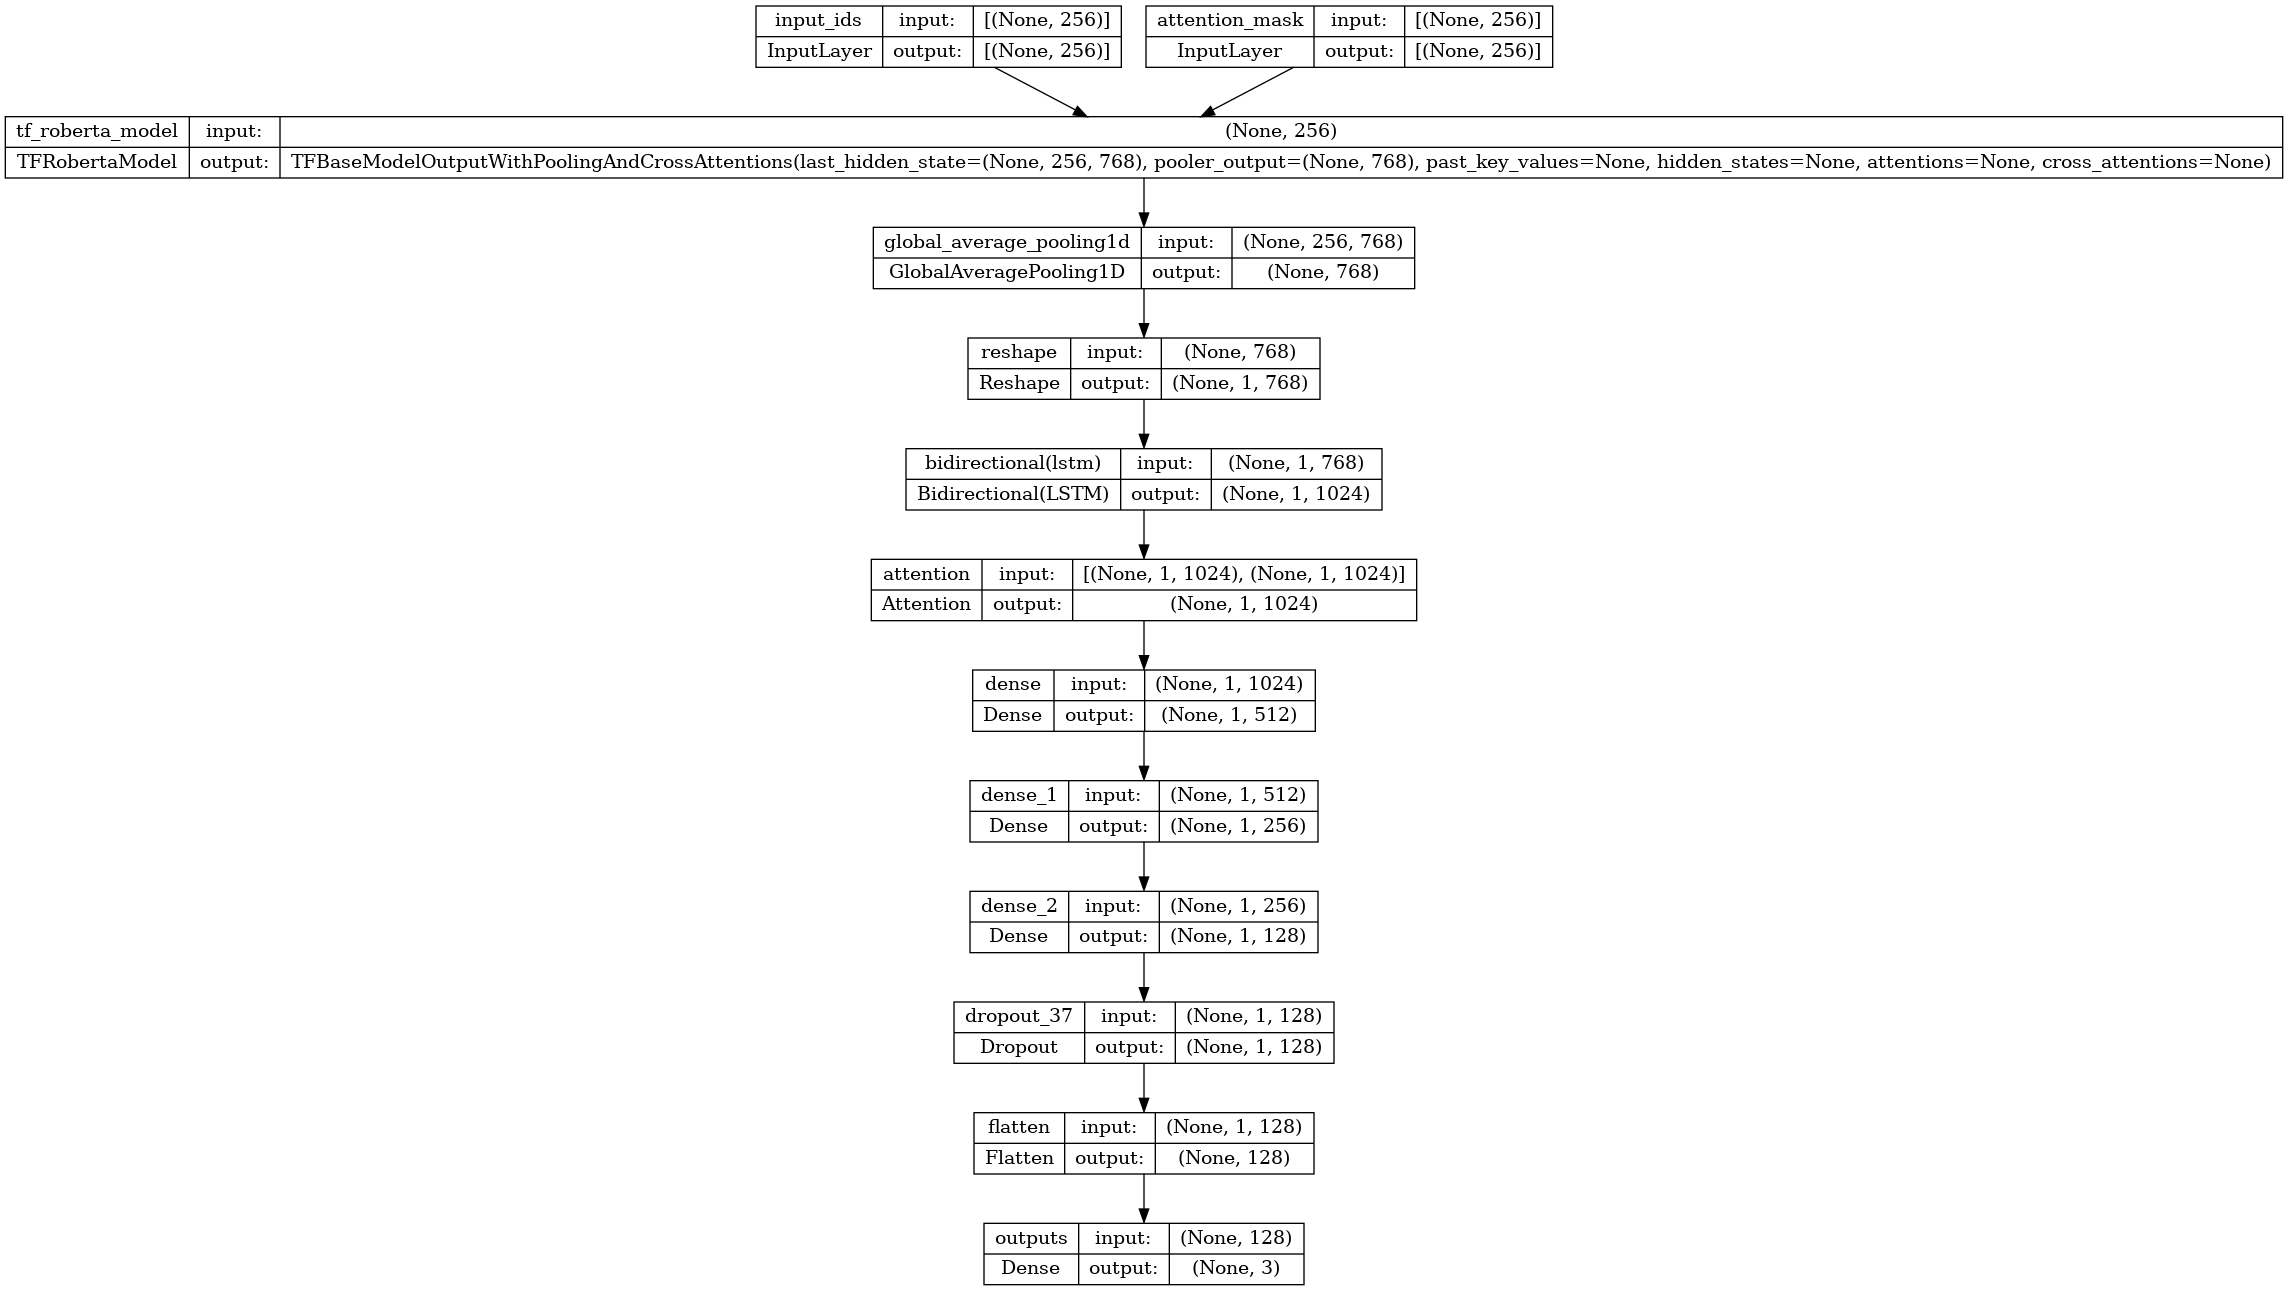

In [42]:
tf.keras.utils.plot_model(bert_model, to_file = 'bert_model1.png', show_shapes=True, show_layer_names = True)

# 📊 Model Evaluation

In [43]:
# For Data Visualization
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import wordcloud

# Miscellaneous
from tqdm import tqdm
import os
import random
from IPython import display

In [44]:
def plot_learning_evolution(r):
    plt.figure(figsize=(8, 6))
    
    #plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('loss1.png')
    
    plt.figure(figsize=(8, 6))
    #plt.subplot(2, 2, 2)
    plt.plot(r.history['categorical_accuracy'], label='categorical_accuracy')
    plt.plot(r.history['val_categorical_accuracy'], label='val_categorical_accuracy')
    plt.title('Accuracy score evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('accuracy1.png')

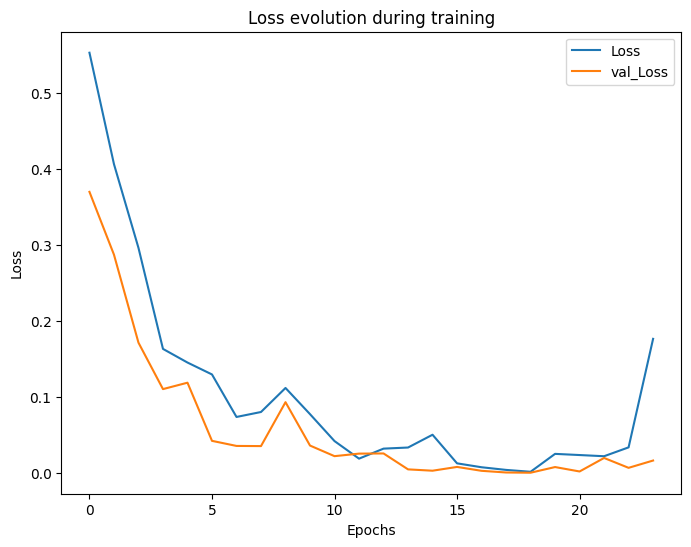

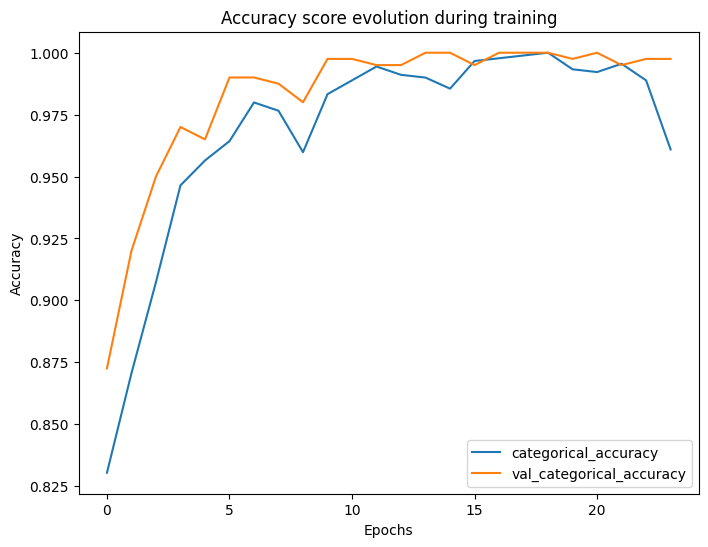

In [54]:
plot_learning_evolution(history)

In [46]:
bert_model.evaluate(val_ds)

25/25 [==============================] - 7s 264ms/step - loss: 2.7165e-04 - categorical_accuracy: 1.0000


[0.00027165445499122143, 1.0]

In [47]:
bert_model.evaluate(train_ds)

56/56 [==============================] - 15s 264ms/step - loss: 8.0533e-04 - categorical_accuracy: 1.0000


[0.0008053257479332387, 1.0]

In [48]:
def prep_data(text):
    tokens = tokenizer(
        text, max_length=seq_len, truncation=True, 
        padding='max_length', 
        add_special_tokens=True, 
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

test['prediction'] = None

for i, row in test.iterrows():
    tokens = prep_data(row['text'])
    #probs = bert_model.predict(tokens)
    probs = bert_model.predict_on_batch(tokens)
    pred = np.argmax(probs)
    test.at[i, 'prediction'] = pred
    
test['prediction'] = test['prediction'].astype(int)
test

,text,target,prediction
670,Strategic steps towards FullTime Trading stock...,1,1
251,RT HorseshoeBmore Holiday Giveaway To ensure y...,1,1
1225,Elgato Launches Thunderbolt 2 Dock with 4 K Re...,1,1
300,YES RT garrettwollman No Apple dont remind me ...,0,0
352,UBS Says Consensus on December Quarter Apple i...,1,1
...,...,...,...
306,Yeeaayyawesome OS X Yosemite 10101 rocckkss m ...,2,2
192,Apple is reportedly hiring fashionfocused staf...,1,1
309,Lol RT MsBiAnCaBiSa MhDaDon Apple I havent dec...,1,1
613,Apple YH News Apples antitrust lawsuit may not...,1,1


In [49]:
labels = ['Negative','Neutral','Positive']
from sklearn.metrics import classification_report
print(classification_report(test['target'], test['prediction'], target_names=labels))

              precision    recall  f1-score   support

    Negative       0.94      0.87      0.90       137
     Neutral       0.89      0.93      0.91       165
    Positive       0.73      0.79      0.76        24

    accuracy                           0.90       326
   macro avg       0.85      0.86      0.86       326
weighted avg       0.90      0.90      0.90       326



In [50]:
test.head()

,text,target,prediction
670,Strategic steps towards FullTime Trading stock...,1,1
251,RT HorseshoeBmore Holiday Giveaway To ensure y...,1,1
1225,Elgato Launches Thunderbolt 2 Dock with 4 K Re...,1,1
300,YES RT garrettwollman No Apple dont remind me ...,0,0
352,UBS Says Consensus on December Quarter Apple i...,1,1


In [51]:
test.target.value_counts()

1    165
0    137
2     24
Name: target, dtype: int64

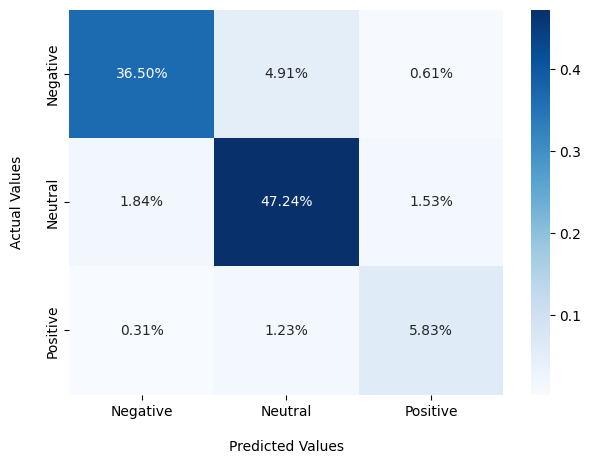

In [52]:
from sklearn.metrics import *
cm = confusion_matrix(test['target'], test['prediction'])

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.savefig('cm.png')
plt.show()

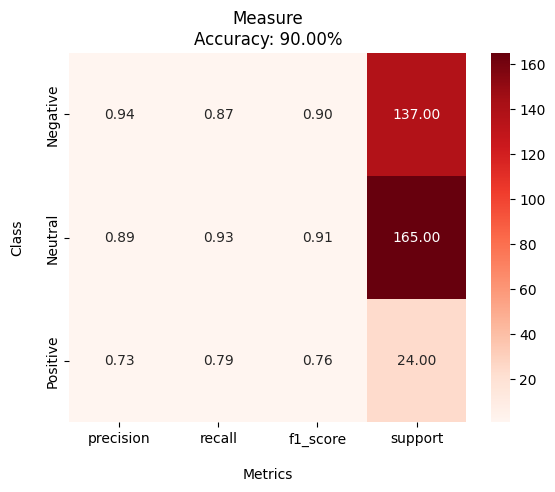

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[1:-3]:
        row = {}
        row_data = line.split()
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df.set_index('class', inplace=True)
    heatmap = sns.heatmap(df, annot=True, cmap='Reds', fmt='.2f')
    heatmap.set_xlabel('\nMetrics')
    heatmap.set_ylabel('Class\n')
    heatmap.set_title('Classification Report')


def accuracy_score(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[4:-2]:
        row_data = line.split()
        row_data = list(filter(None, row_data))
        return float(row_data[1])


labels = ['Negative','Neutral','Positive']

report = classification_report(test['target'], test['prediction'], target_names=labels)
plot_classification_report(report)
accuracy = accuracy_score(report)

plt.title('Measure\nAccuracy: {:.2f}%'.format(accuracy*100))
plt.savefig('classification_reports.png')
plt.show()
